In [2]:
# pnadas to read data frames
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# for NLP
import re #regular expressions
import nltk 
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
import string

# for train test split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Supervised learning algorithms  
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For algorithm evalution
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mehbo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# read data file
movie_df = pd.read_csv('IMDBDataset.csv')

In [4]:
# remove duplicates
movie_df['dup'] = movie_df.duplicated(subset=None, keep='first')
del movie_df['dup']

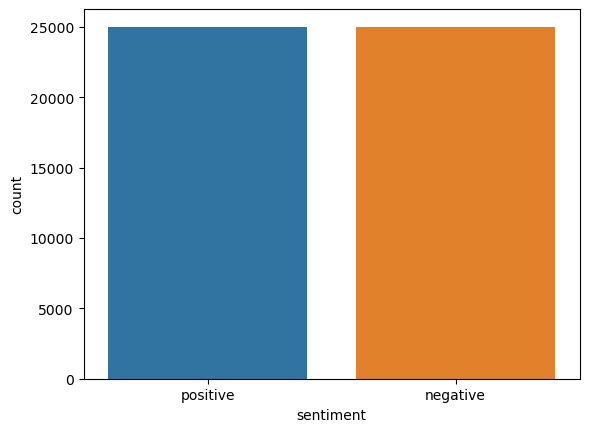

In [5]:
ax = sns.countplot(x="sentiment", data=movie_df)

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Initialize stopwords and lemmatizer
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess(text):
    
    text = text.lower() # Convert to lowercase
    
    # Replace everything except a-z, A-Z, ".", "?", "!", "," with space
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Remove HTML tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)

    # Remove punctuations
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '')

    # Remove stopwords
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    # Lemmatize the words and remove those in the custom stopwords list (if any)
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text) # Joining back into a string

    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # Remove emojis
    
    return text


In [7]:
# Apply preprocessing to review column
movie_df['prep'] = movie_df['review'].apply(lambda x: preprocess(x)) 
del movie_df['review'] # remove review column


In [8]:
# Tokenize the preprocessed text
movie_df['tokens'] = movie_df['prep'].apply(lambda x: re.findall(r"[\w']+", x))

In [9]:
X_train, X_test , y_train, y_test = train_test_split(movie_df['prep'].values,
                                                     movie_df['sentiment'].values,test_size=0.2,
                                                     random_state=42,stratify=movie_df['sentiment'].values)

In [10]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [34]:
classifier1 = RandomForestClassifier()
classifier1.fit(tfidf_train_vectors,y_train)

y_pred1 = classifier1.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred1))
print("Accuracy score:", accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      5000
    positive       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy score: 0.8605


<Axes: >

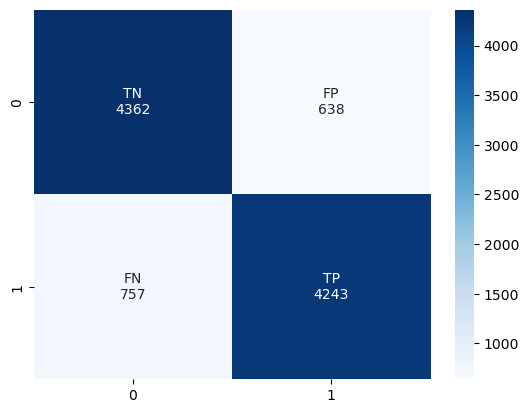

In [35]:
# generate confusion matrix print the name of algo
cnf_matrix = confusion_matrix(y_test,y_pred1)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

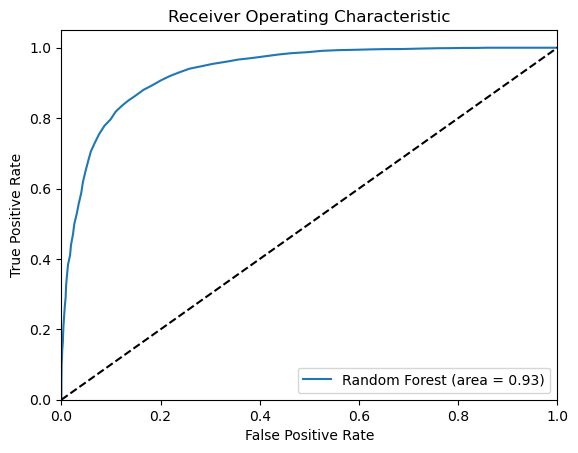

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = classifier1.predict_proba(tfidf_test_vectors)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label='positive') # Adjust pos_label as per your data
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


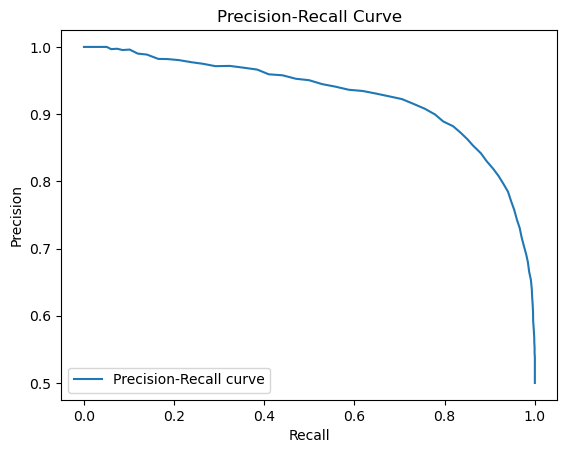

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_scores = classifier1.predict_proba(tfidf_test_vectors)[:, 1]

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='positive')  # Adjust pos_label as per your data

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train Logistic Regression
classifier2 = LogisticRegression()
classifier2.fit(tfidf_train_vectors, y_train)

# Evaluate Logistic Regression
y_pred2 = classifier2.predict(tfidf_test_vectors)

# Print the classification report
print(classification_report(y_test, y_pred2))

# Print the accuracy score
print("Accuracy score:", accuracy_score(y_test, y_pred2))


              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy score: 0.8955


In [61]:
classifier2 = DecisionTreeClassifier()
classifier2.fit(tfidf_train_vectors,y_train)

y_pred2 = classifier2.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred2))
print("Accuracy score:", accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      5000
    positive       0.72      0.72      0.72      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

Accuracy score: 0.7225


<Axes: >

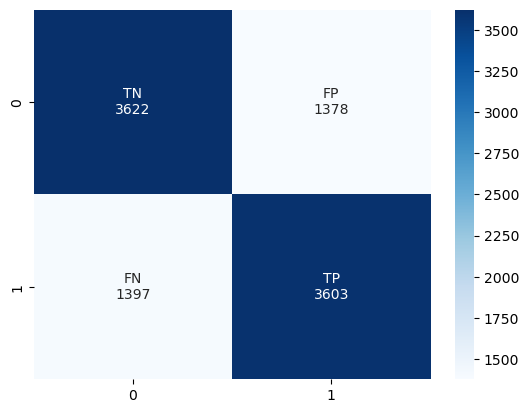

In [62]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred2)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

In [63]:
classifier3 = MultinomialNB()
classifier3.fit(tfidf_train_vectors,y_train)

y_pred3 = classifier3.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred3))
print("Accuracy score:", accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      5000
    positive       0.88      0.85      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy score: 0.868


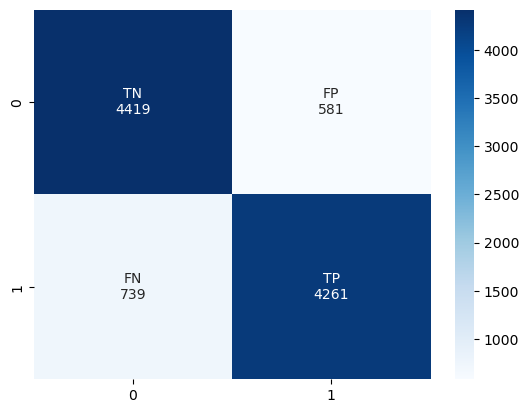

In [64]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred3)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [65]:
classifier4 = KNeighborsClassifier()
classifier4.fit(tfidf_train_vectors,y_train)

y_pred4 = classifier4.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred4))
print("Accuracy score:", accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

    negative       0.79      0.73      0.76      5000
    positive       0.75      0.80      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy score: 0.7678


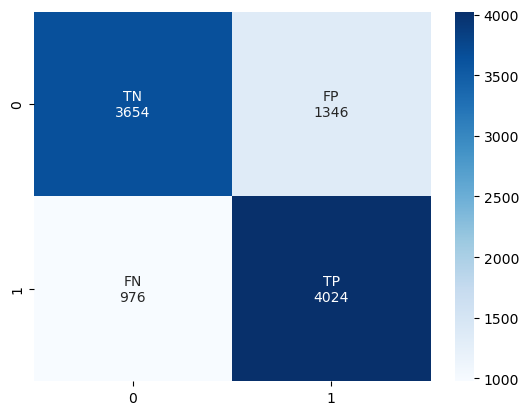

In [66]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred4)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [11]:
classifier5 = LogisticRegression()
classifier5.fit(tfidf_train_vectors,y_train)
y_pred5 = classifier5.predict(tfidf_test_vectors)
print(classification_report(y_test,y_pred5))
print("Accuracy score:", accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy score: 0.8955


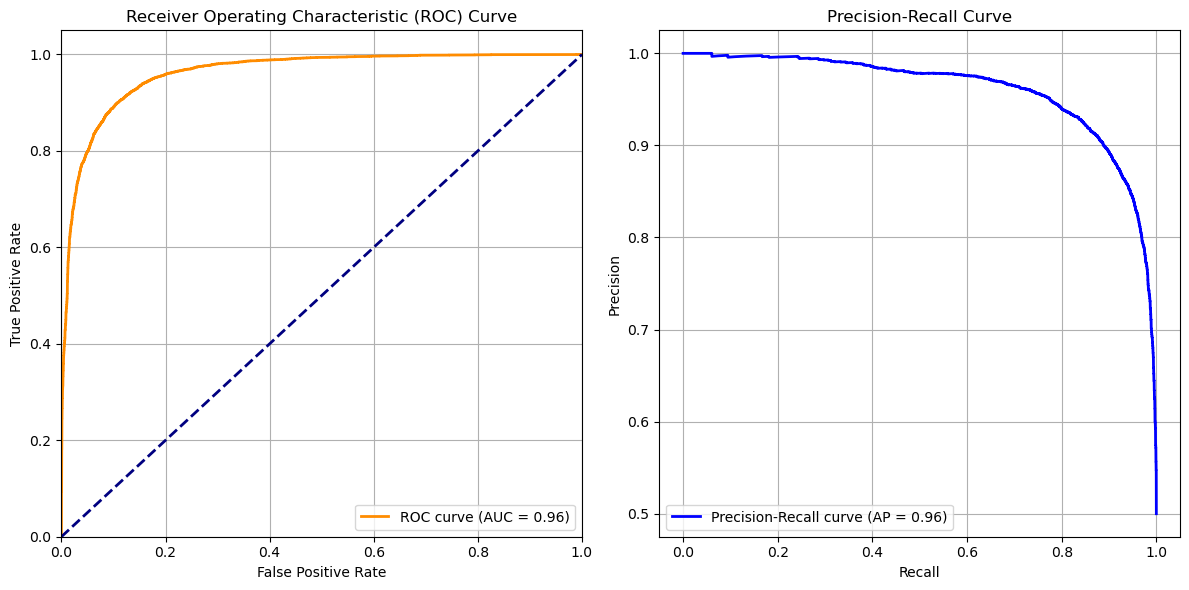

In [12]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_test and classifier5 are already defined and classifier5 is trained.

# Convert categorical labels to binary
y_test_binary = np.where(y_test == 'positive', 1, 0)

# Get the probability scores for the positive class
y_pred_prob = classifier5.predict_proba(tfidf_test_vectors)[:, 1]

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_binary, y_pred_prob)
average_precision = average_precision_score(y_test_binary, y_pred_prob)

# Plotting both the ROC and Precision-Recall Curves in one plot
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

# Show the combined plot
plt.tight_layout()
plt.show()


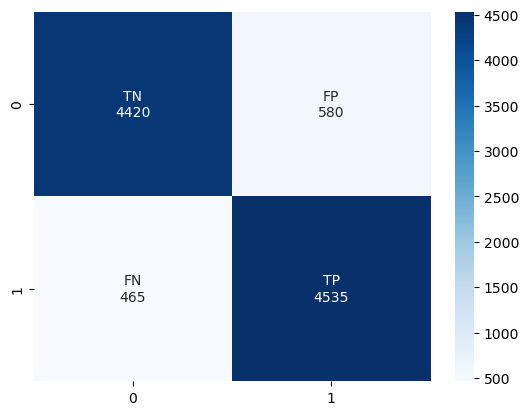

In [13]:
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred5)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [69]:
classifier6 = AdaBoostClassifier()
classifier6.fit(tfidf_train_vectors,y_train)

y_pred6 = classifier6.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred6))
print("Accuracy score:", accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

    negative       0.82      0.77      0.79      5000
    positive       0.78      0.83      0.81      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Accuracy score: 0.8013


In [70]:
classifier7 = SVC()
classifier7.fit(tfidf_train_vectors,y_train)

y_pred7 = classifier7.predict(tfidf_test_vectors)

print(classification_report(y_test,y_pred7))
print("Accuracy score:", accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy score: 0.9008


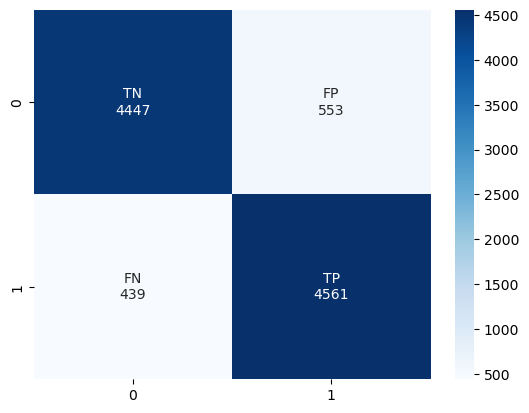

In [71]:
# generate confusion matrix 
cnf_matrix = confusion_matrix(y_test,y_pred7)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');



In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Assuming movie_df is already defined and preprocessed

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    movie_df['prep'].values,
    movie_df['sentiment'].values,
    test_size=0.2,
    random_state=42,
    stratify=movie_df['sentiment'].values
)

# Define the pipeline
pipe = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer()),
    ('logisticregression', LogisticRegression(solver='saga'))
])

# Define the parameter grid
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__max_iter': [500]
}

# Create GridSearchCV object
grid = GridSearchCV(pipe, param_grid, cv=5)

# Fit the model
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid.best_params_)

# Predict on test data
y_pred = grid.predict(X_test)

# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred))


Best parameters found: {'logisticregression__C': 100, 'logisticregression__max_iter': 500, 'tfidfvectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      5000
    positive       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Accuracy score: 0.9077


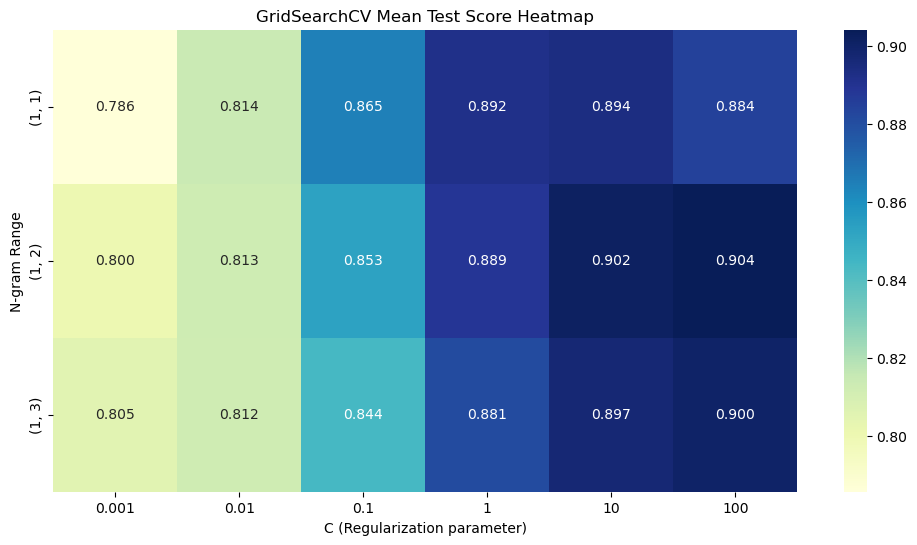

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extracting results from the GridSearchCV
results = pd.DataFrame(grid.cv_results_)

# Filtering results for readability (focusing on 'C' and 'ngram_range', with 'max_iter' at its best value)
filtered_results = results[(results['param_logisticregression__max_iter'] == grid.best_params_['logisticregression__max_iter'])]

# Pivoting the data for heatmap
pivot_table = filtered_results.pivot(
    index='param_tfidfvectorizer__ngram_range',
    columns='param_logisticregression__C',
    values='mean_test_score'
)

# Creating the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('GridSearchCV Mean Test Score Heatmap')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('N-gram Range')
plt.show()


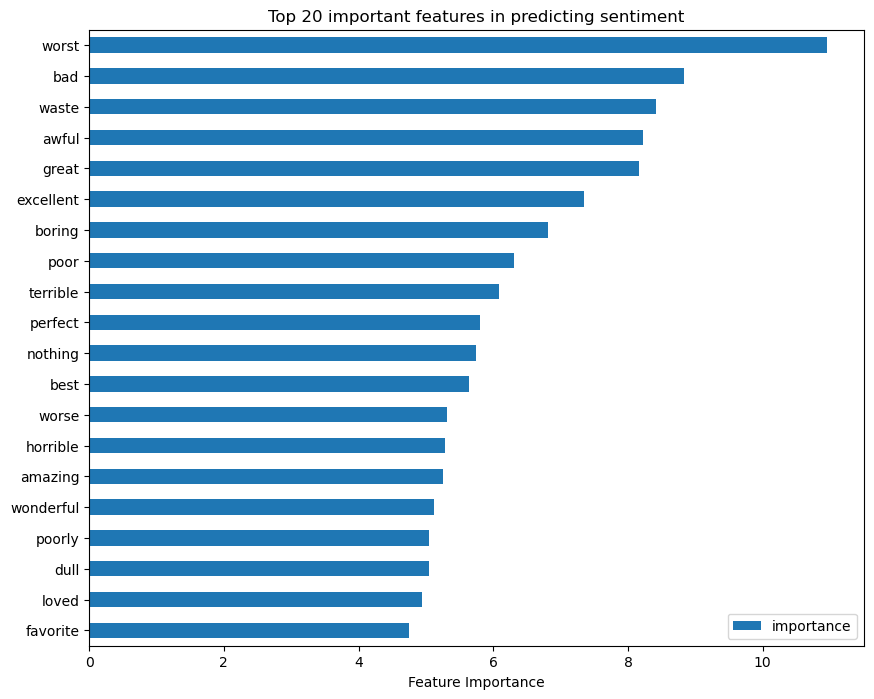

In [17]:
# Fit the model
classifier = LogisticRegression(solver='saga', random_state=42)
classifier.fit(tfidf_train_vectors, y_train)

# Get feature names from the TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients from the Logistic Regression model
coefficients = classifier.coef_.flatten()

# Map coefficients to feature names
feature_importances = pd.DataFrame(coefficients, index=feature_names, columns=['importance'])

# Sort the features by the absolute value of their coefficient
sorted_features = feature_importances.abs().sort_values(by='importance', ascending=False)

# Visualize the top 20 features
top_features = sorted_features.head(20)
ax = top_features.sort_values(by='importance').plot(kind='barh', figsize=(10, 8))
ax.set_title('Top 20 important features in predicting sentiment')
ax.set_xlabel('Feature Importance')
plt.show()


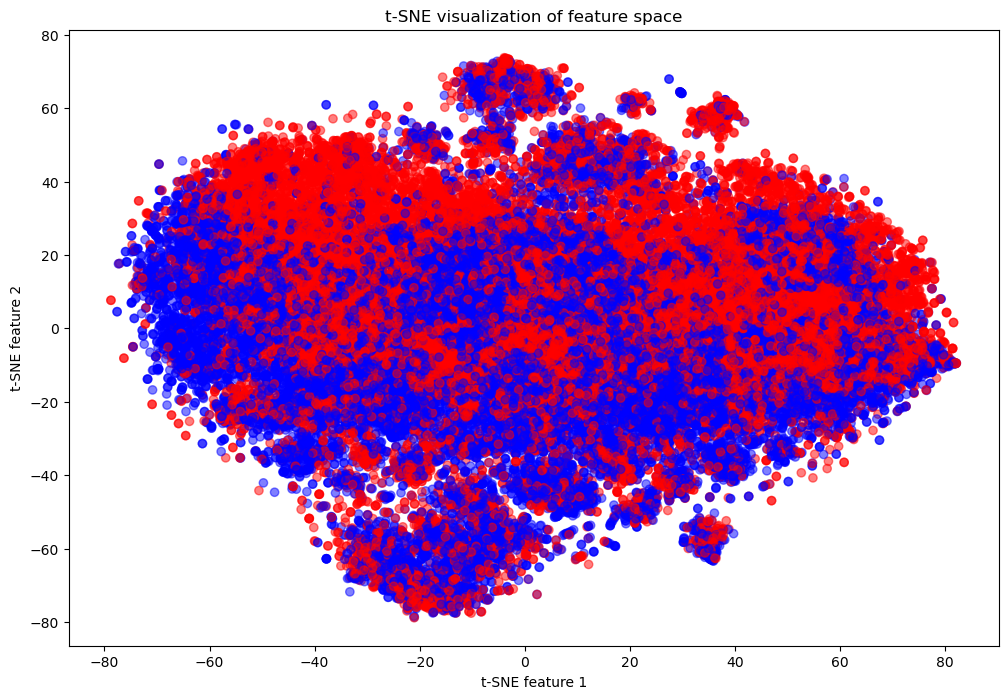

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming tfidf_train_vectors is your TF-IDF sparse matrix from the training data
# We will first reduce the number of features to a manageable amount using truncated SVD (similar to PCA)
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(tfidf_train_vectors)

# Now we apply t-SNE to the reduced data
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

# Convert the target labels to colors to visualize separation
colors = ['red' if label == 'negative' else 'blue' for label in y_train]

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, alpha=0.5)

# Label the plot
plt.title('t-SNE visualization of feature space')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


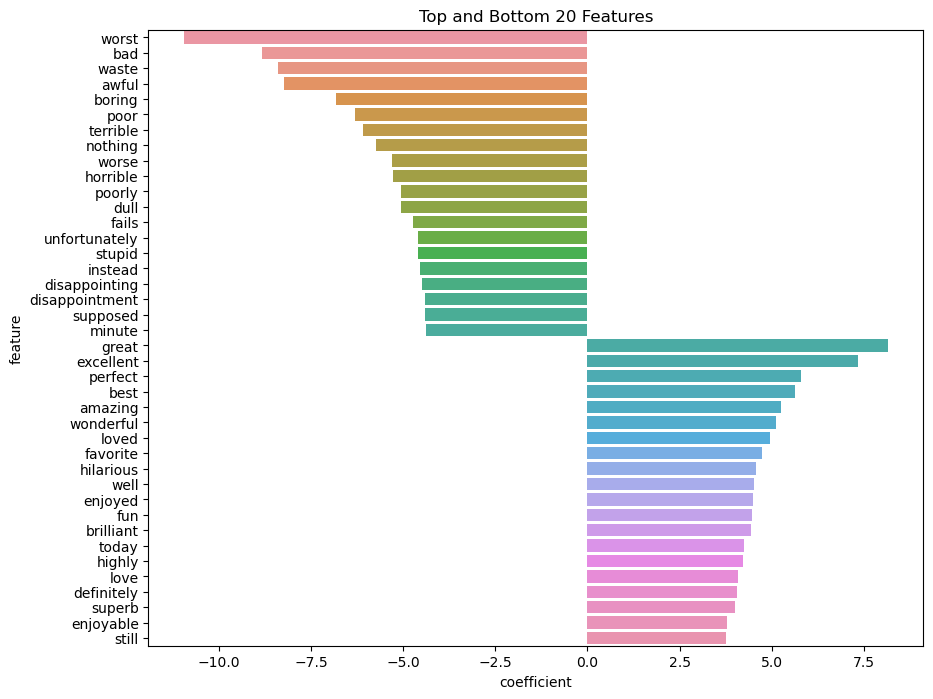

In [21]:
# Assuming that tfidf_vectorizer and classifier5 are your trained TfidfVectorizer and LogisticRegression instances
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = classifier5.coef_.flatten()


# Create a DataFrame with features and coefficients
feature_importance = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

import matplotlib.pyplot as plt

# Get the top 20 positive features and the top 20 negative features
top_features = feature_importance.sort_values(by='coefficient', ascending=False).head(20)
bottom_features = feature_importance.sort_values(by='coefficient').head(20)

# Combine the dataframes
important_features = pd.concat([bottom_features, top_features])

# Plot the features
plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=important_features)
plt.title('Top and Bottom 20 Features')
plt.show()



In [29]:
%pip install wordcloud


  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   ------- ------------------------------- 61.4/300.2 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


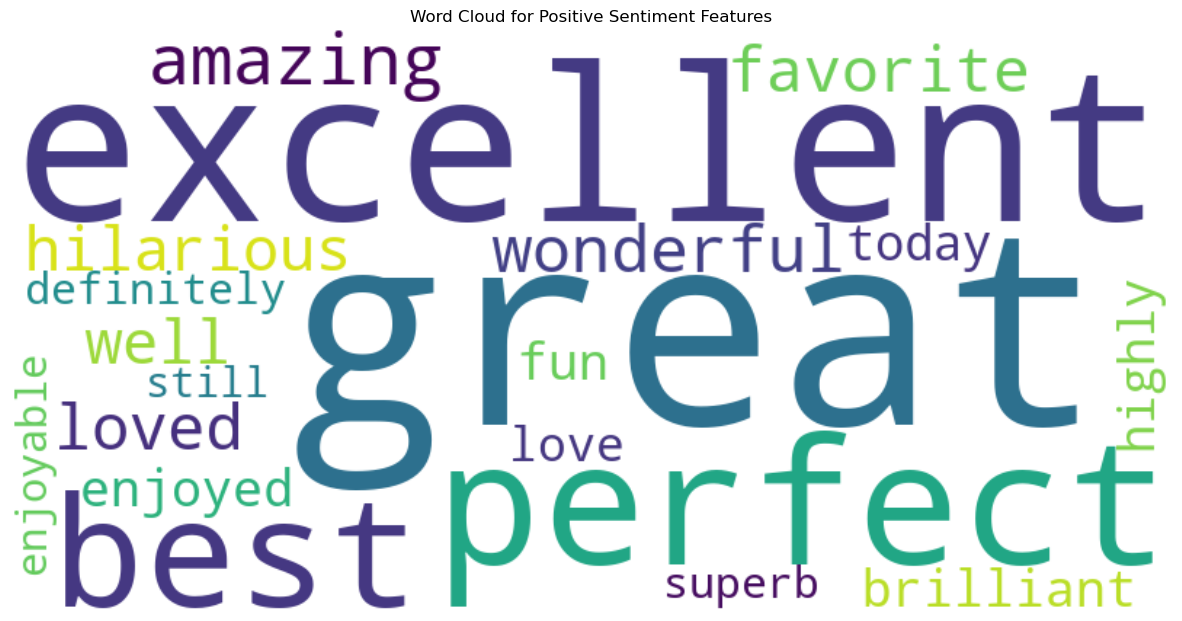

In [30]:
from wordcloud import WordCloud

# Generate a word cloud image for positive sentiment features
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_features.feature, top_features.coefficient)))

# Display the cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Features')
plt.show()


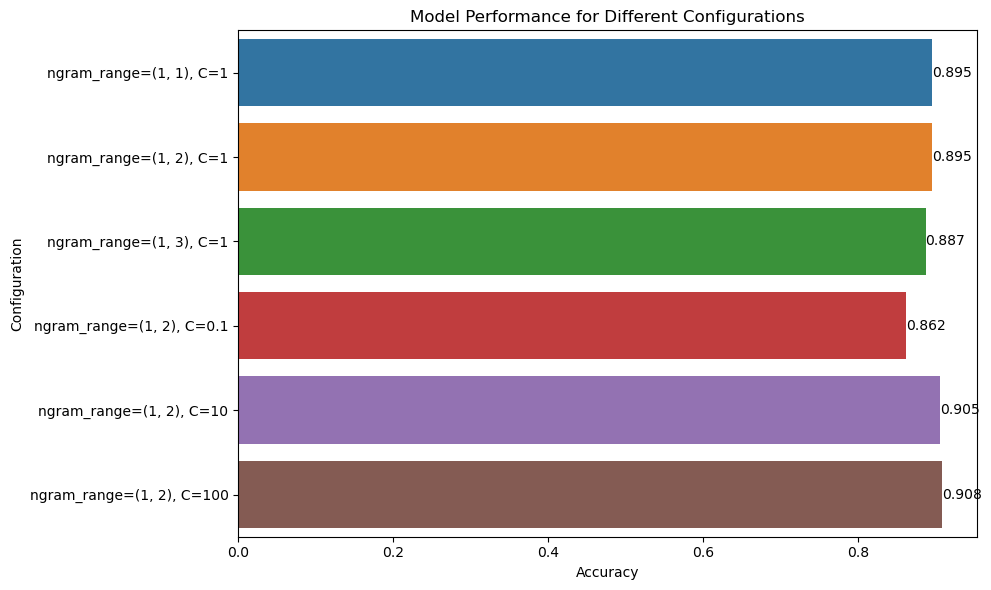

In [32]:
from sklearn.metrics import classification_report, accuracy_score

# Define the different parameter configurations you want to test
configurations = [
    {'ngram_range': (1, 1), 'C': 1},
    {'ngram_range': (1, 2), 'C': 1},
    {'ngram_range': (1, 3), 'C': 1},
    {'ngram_range': (1, 2), 'C': 0.1},
    {'ngram_range': (1, 2), 'C': 10},
    {'ngram_range': (1, 2), 'C': 100},
    # Add more configurations as needed
]

# Store the results for each configuration
results = []

for config in configurations:
    # Update the vectorizer and classifier with the current configuration
    tfidf_vectorizer = TfidfVectorizer(ngram_range=config['ngram_range'])
    classifier = LogisticRegression(solver='saga', C=config['C'], max_iter=500)

    # Transform the data
    tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
    tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

    # Train the classifier
    classifier.fit(tfidf_train_vectors, y_train)

    # Make predictions
    y_pred = classifier.predict(tfidf_test_vectors)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results.append({
        'Configuration': f'ngram_range={config["ngram_range"]}, C={config["C"]}',
        'Accuracy': accuracy,
        'F1-score': report['weighted avg']['f1-score']
    })

# Convert results to a DataFrame for easier visualization
import pandas as pd

results_df = pd.DataFrame(results)

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Create the bar plot
barplot = sns.barplot(x='Accuracy', y='Configuration', data=results_df, ci=None)

# Add the text annotations on each bar
for p in barplot.patches:
    width = p.get_width()    # Get the width of the bar
    plt.text(width,          # Set the x position to the end of the bar
             p.get_y() + p.get_height() / 2, # Set the y position to the center of the bar
             '{:1.3f}'.format(width), # Format the number to three decimal places
             ha = 'left',   # Align the text to the left
             va = 'center') # Center the text vertically

plt.title('Model Performance for Different Configurations')
plt.xlabel('Accuracy')
plt.ylabel('Configuration')
plt.tight_layout()
plt.show()


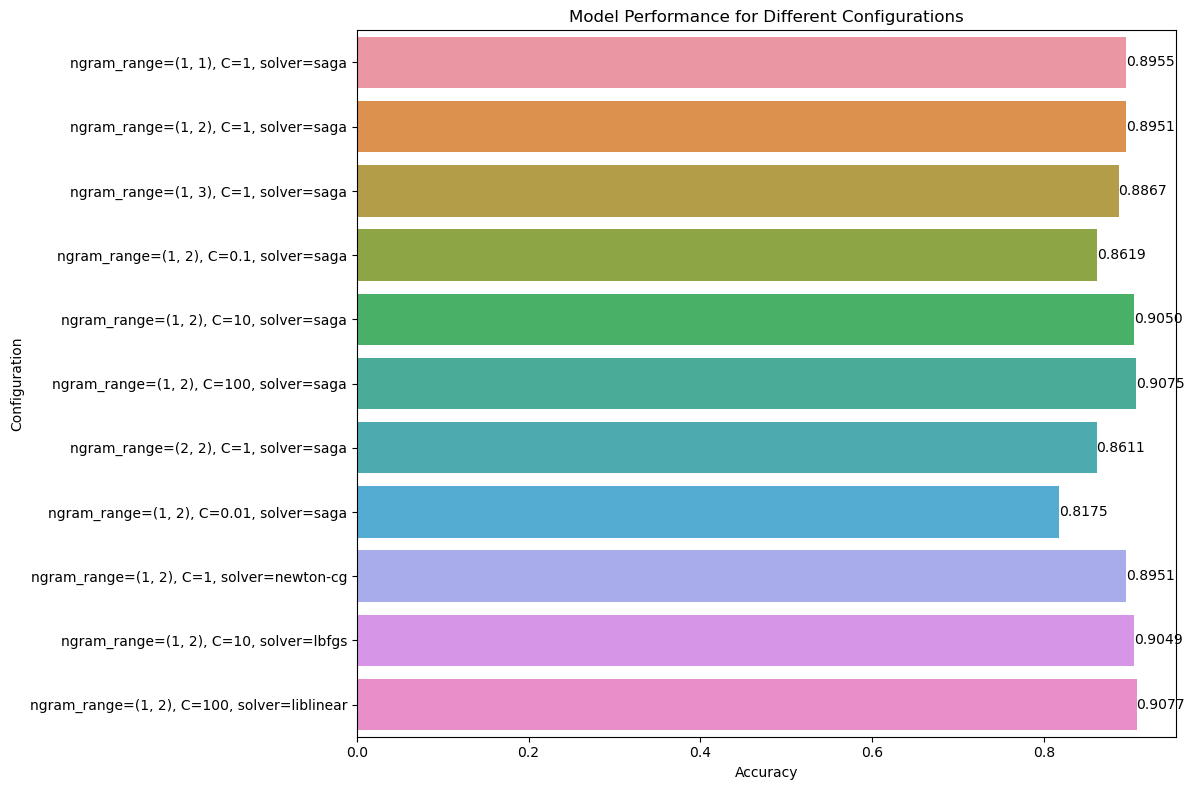

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming movie_df is already defined and preprocessed
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    movie_df['prep'].values,
    movie_df['sentiment'].values,
    test_size=0.2,
    random_state=42,
    stratify=movie_df['sentiment'].values
)

# Define the different parameter configurations you want to test, including new ones
configurations = [
    {'ngram_range': (1, 1), 'C': 1},
    {'ngram_range': (1, 2), 'C': 1},
    {'ngram_range': (1, 3), 'C': 1},
    {'ngram_range': (1, 2), 'C': 0.1},
    {'ngram_range': (1, 2), 'C': 10},
    {'ngram_range': (1, 2), 'C': 100},
    # New configurations based on the feedback
    {'ngram_range': (2, 2), 'C': 1},
    {'ngram_range': (1, 2), 'C': 0.01},
    {'ngram_range': (1, 2), 'solver': 'newton-cg'},
    {'ngram_range': (1, 2), 'C': 10, 'solver': 'lbfgs'},
    {'ngram_range': (1, 2), 'C': 100, 'solver': 'liblinear'},
    # Add more configurations as needed
]

# Store the results for each configuration
results = []

for config in configurations:
    # Update the vectorizer and classifier with the current configuration
    tfidf_vectorizer = TfidfVectorizer(ngram_range=config.get('ngram_range', (1, 1)))
    classifier = LogisticRegression(
        solver=config.get('solver', 'saga'),
        C=config.get('C', 1),
        max_iter=500
    )

    # Transform the data
    tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
    tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

    # Train the classifier
    classifier.fit(tfidf_train_vectors, y_train)

    # Make predictions
    y_pred = classifier.predict(tfidf_test_vectors)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results.append({
        'Configuration': f'ngram_range={config.get("ngram_range", (1, 1))}, C={config.get("C", 1)}, solver={config.get("solver", "saga")}',
        'Accuracy': accuracy,
        'F1-score': report['weighted avg']['f1-score']
    })

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Visualize the results
plt.figure(figsize=(12, 8))

# Create the bar plot
barplot = sns.barplot(x='Accuracy', y='Configuration', data=results_df, ci=None)

# Add the text annotations on each bar
for p in barplot.patches:
    width = p.get_width()    # Get the width of the bar
    plt.text(width,          # Set the x position to the end of the bar
             p.get_y() + p.get_height() / 2, # Set the y position to the center of the bar
             '{:1.4f}'.format(width), # Format the number to four decimal places
             ha = 'left',   # Align the text to the left
             va = 'center') # Center the text vertically

plt.title('Model Performance for Different Configurations')
plt.xlabel('Accuracy')
plt.ylabel('Configuration')
plt.tight_layout()
plt.show()
